# Project 4 - Analysis of Marathon Results

### Nicholas Colan | UB: 5014 2568
### MTH 448 | 04/28/23

## Introduction

In this report we will explore runner data from a marathon race. This data contains information about each specific runner such as their age, gender, and country of origin. On top of that, each runner's race data is present, with their total split times for each successive 5 km all the way up to their finish time. We will use several methods to predict things about each runner in this report.

We will start by using 1-dimension and 2-dimension `Kernel Density Estimates(KDE)` in conjunction with `Bayes Theorem` to try to predict whether or not a runner was male or female. A kernel density estimate is a method that estimates the probability density function of a random variable. Estimating the density of each point is done by adding up the weights from nearby points using a kernel function around each data point, and then summing up the weights of all kernels. The KDE also has a bandwidth parameter that allows one to control the width of the kernel, and therefore change the 'smoothness' of the graph of the KDE of a dataset. 

Bayesian inference is a statistical method used to predict outcomes about prior unknown events. This method uses Thomas Bayes' theorem, which uses prior knowledge about related events to make a prediction about the outcome of future events. We will use use Bayes Theorem in conjunction with KDE and different datapoints to make predictions about the gender of the runners.

Next, we will see how these results compare with results using a `k-Nearest Neighbors(kNN)` classifier to see if this method works better or worse than when using kNN. 

Lastly, we will use linear regression to predict the total finish time in minutes of a runner given certain parameters. Some of these parameters will include the runner's age, gender, and different split times. We will see if we can build a regression model using data from pre-race and early stages of the race that can predict the finish time of a runner with a low degree of error.

In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from scipy.stats import norm, gaussian_kde
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

Let's start by taking a look at our data and how the dataset is constructed. We can see that every split time is represented in a `hh:mm:ss` format, which we will want to convert to minutes in order to be able to quickly process and perform calculations on. We will use `timedelta's` to convert this formatted number to seconds, and then divide by 60 to get the time to minutes.

In [2]:
marathon_results_df = pd.read_csv('marathon_results.csv')
marathon_results_df['tot_minutes'] = pd.to_timedelta(marathon_results_df['Finish']).dt.total_seconds()/60
marathon_results_df.head(1)

,Age,M/F,Country,5K,10K,15K,20K,Half,25K,30K,35K,40K,Finish,Pace,Overall,Gender,Division,tot_minutes
0,25,M,ETH,00:14:43,00:29:43,00:44:57,01:00:29,01:04:02,01:16:07,01:32:00,01:47:59,02:02:39,02:09:17,00:04:56,1,1,1,129.283333


We want to first split our data into training and testing data, we will use `80%` for training data and `20%` for testing data. From there let's seperate the dataset into male and female data using the `M/F` column.

In [3]:
marathon_train_df,marathon_test_df = train_test_split(marathon_results_df,test_size=0.2,random_state=123)

In [4]:
male_times_df = marathon_train_df[marathon_train_df['M/F']=='M']
female_times_df = marathon_train_df[marathon_train_df['M/F']=='F']

### 1-D Kernel Density Estimate

We will start with a bandwidth value of `0.1` for our KDE:

Now we will use this kernel density estimate in conjunction with Bayes' Theorem to predict whether or not the runner was male or female. Bayes' Theroem states:

$P(H|E) = \frac{P(E|H)*P(H)}{P(E)}$ , where:

* P(H) = Probability of the hypothesis 
* P(E) = Probability of evidence

If we want to predict whether or not the runner was female`('F')` given their finish time`('tot_minutes')` we would have:

$P(F|totalMinutes) = \frac{P(totalMinutes|F)*P(F)}{P(totalMinutes)}$ `[1]`

The probability that a runner was female, `P(F)`, is easy to calculate, we will just divide the number of females by the number of total marathon participants:

In [7]:
prob_male = len(male_times_df) / (len(male_times_df)+len(female_times_df))
prob_female = len(female_times_df) / (len(male_times_df)+len(female_times_df))
print('Males: {:}%'.format(prob_male*100))
print('Females: {:}%'.format(prob_female*100))

Males: 54.7723167601483%
Females: 45.22768323985169%


We can see that a little over `45%` of the total participants in the marathon were female. Now we want to calculate the probability of a finish time `tot_minutes` given that the runner was female, `P(totalMinutes|F)`.

We want to compute the estimated probability density of the finish time `tot_minutes` under the female runners' kernel density estimate. To do this we will use our calculated Kernel Density Estimate to calculate the estimated probability density at the point.

To calculate `P(totMinutes)`, we need to calculate:

$P(totMinutes|F)P(F) + P(totMinutes|F')P(F')$, where F' inverse of female which would equal male, giving us:

$P(totMinutes) = P(totMinutes|F)P(F) + P(totMinutes|M)P(M)$.  `[1]`

With our Bayes equation and KDE set, we can use these two to predict whether a runner was male or female given their finish time. If we calculate our probability of a runner being female given their finish time to be more than the probability that the unner was male, we will predict that runner was female. If not, we will predict that the runner was a male. The method `bayes_prediction_1D_KDE()` takes three parameters:

* `testing_data` - Our test marathon data
* `kde_males` - The gaussian kde of male runner times
* `kde_females` - The gaussian kde of female runner times

And returns the percentage of correct predictions as well as a list of predictions.

In [8]:
def bayes_prediction_1D_KDE(testing_data,kde_males,kde_females):
    runner_gender_predictions = []
    correct = 0
    
    # Iterate through each row of the dataframe
    for index,row in testing_data.iterrows():
        predicted_gender = ''
        tot_min = row['tot_minutes']
        gender = row['M/F']

        # Compute the kde of a total time for males/females
        prob_tot_minutes_given_male = kde_males(tot_min)
        prob_tot_minutes_given_female = kde_females(tot_min)
        # Compute P(totalMinutes)
        prob_tot_minutes = (prob_tot_minutes_given_female * prob_female) + (prob_tot_minutes_given_male * prob_male)
        # Now compute bayes for male/female
        probability_female_given_tot_minutes = (prob_tot_minutes_given_female * prob_female) / prob_tot_minutes
        probability_male_given_tot_minutes = (prob_tot_minutes_given_male * prob_male) / prob_tot_minutes


        # If probability for bayes female > bayes male, say that the runner was female and vice versa
        if probability_female_given_tot_minutes > probability_male_given_tot_minutes:
            predicted_gender = 'F'
        elif probability_female_given_tot_minutes < probability_male_given_tot_minutes: 
            predicted_gender = 'M'
        if predicted_gender == gender:
            correct += 1
        runner_gender_predictions.append(predicted_gender)
            
    return((correct/len(testing_data))*100,runner_gender_predictions)

In [10]:
# Calculate the KDE for males and females
kde_males = gaussian_kde(male_times_df['tot_minutes'],bw_method=.1)
kde_females = gaussian_kde(female_times_df['tot_minutes'],bw_method=.1)

bayes_prediction_1D_KDE(marathon_test_df,kde_males,kde_females)[0]

65.34220532319391

We can see that we were able to correctly predict the gender of the runner about `65%` of the time when using 1-D KDE in conjunction with Bayes theorem when using a bandwidth value of `0.1`. Let's test bandwidth values between `0.1 and 2` to see how much the classification accuracy changes. The commented out code below will generate and save these results in a file named `accuracy_kde1D.txt` for quick access.

In [11]:
#class_acc_kde_1d = []
#for i in range(1,21,1): 
    #bw = i/10
    #kde_males_1D = gaussian_kde(male_times_df['tot_minutes'], bw_method=bw)
    #kde_females_1D = gaussian_kde(female_times_df['tot_minutes'], bw_method=bw)
    #accuracy = bayes_prediction_1D_KDE(marathon_test_df,kde_males_1D,kde_females_1D)[0]
    #class_acc_kde_1d.append((bw,accuracy))

In [12]:
#with open('accuracy_kde1D.txt','w') as f:
    #for line in class_acc_kde_1d:
        #f.write('{:} | {:}'.format(line[0],line[1]))
        #f.write('\n')

In [13]:
with open('accuracy_kde1D.txt','r') as f:
    # These values get stored in the file as a string with format: bandwidth | accuracy
    # Split on ' | ' and convert to float for visualization
    results_1D = np.array([value.strip().split(' | ') for value in f],dtype=float)

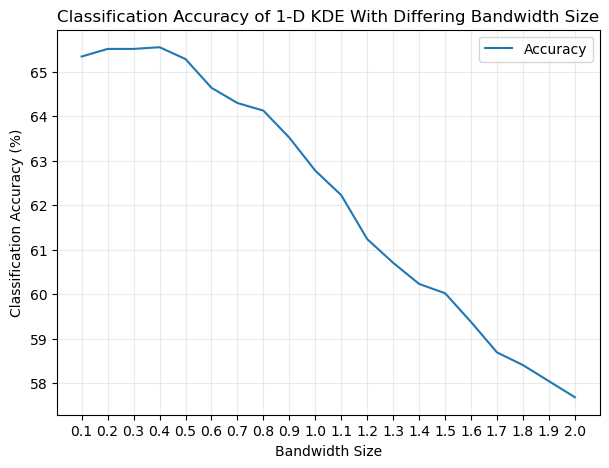

In [15]:
x_1d = [value[0] for value in results_1D]
y_1d = [value[1] for value in results_1D]


plt.figure(figsize=(7,5),dpi=100)
plt.plot(x_1d,y_1d,label='Accuracy')
plt.xticks(ticks=x_1d)
plt.xlabel('Bandwidth Size')
plt.ylabel('Classification Accuracy (%)')
plt.title('Classification Accuracy of 1-D KDE With Differing Bandwidth Size')
plt.legend()
# Create a grid on the plot for visualization, 'alpha' parameter sets opacity
plt.grid(True,alpha=0.25)
plt.show()

We can see that at a bandwidth size of `0.4`, we get our most accurate classification of about `65.5%`. We can also see that as the bandwidth size continues to increase, the classification accuracy drops.

### 2-D Kernel Density Estimate

We will now also factor in age in addition to total minutes to predict our runners' genders, this will be a 2-Dimensional KDE. The method `bayes_prediction_2D_KDE()` takes three parameters:

* `testing_data` - Our test marathon data
* `kde_males` - The gaussian kde of male runner times
* `kde_females` - The gaussian kde of female runner times

And returns the percentage of correct predictions as well as a list of predictions.

In [16]:
def bayes_prediction_2D_KDE(testing_data,kde_males,kde_females):
    runner_gender_predictions = []
    correct = 0
    
    for index,row in testing_data.iterrows():
        predicted_gender = ''
        tot_min = row['tot_minutes']
        gender = row['M/F']
        age = row['Age']

        prob_tot_minutes_age_given_male = kde_males((tot_min,age)) 
        prob_tot_minutes_age_given_female = kde_females((tot_min,age))
        prob_tot_minutes_age = (prob_tot_minutes_age_given_female * prob_female) + (prob_tot_minutes_age_given_male * prob_male)
        probability_female_given_tot_minutes_age = (prob_tot_minutes_age_given_female * prob_female) / prob_tot_minutes_age
        probability_male_given_tot_minutes_age = (prob_tot_minutes_age_given_male * prob_male) / prob_tot_minutes_age


        if probability_female_given_tot_minutes_age > probability_male_given_tot_minutes_age:
            predicted_gender = 'F'
        elif probability_female_given_tot_minutes_age < probability_male_given_tot_minutes_age: 
            predicted_gender = 'M'
        if predicted_gender == gender:
            correct += 1
        runner_gender_predictions.append(predicted_gender)

    return((correct/len(testing_data))*100,runner_gender_predictions)

In [17]:
kde_males_2D = gaussian_kde(male_times_df[['tot_minutes','Age']].T, bw_method=.1)
kde_females_2D = gaussian_kde(female_times_df[['tot_minutes','Age']].T, bw_method=.1)

bayes_prediction_2D_KDE(marathon_test_df,kde_males_2D,kde_females_2D)[0]

76.00760456273764

We can see that when adding in an additional dimension to the KDE, our classification accuracy improved to `76%`. This is a nice improvement of over `10%` compared to the 1-D KDE model. Now let's see how different values of bandwith affect this 2-D KDE. We will look at values between `0.1 and 2`. The commented out code below will generate and save these results in a file named `accuracy_kde2D.txt` for quick access.

In [18]:
#class_acc_kde_2d = []
#for i in range(1,21,1): 
    #bw = i/10
    #kde_males_2D = gaussian_kde(male_times_df[['tot_minutes','Age']].T, bw_method=bw)
    #kde_females_2D = gaussian_kde(female_times_df[['tot_minutes','Age']].T, bw_method=bw)
    #accuracy = bayes_prediction_2D_KDE(marathon_test_df,kde_males_2D,kde_females_2D)[0]
    #class_acc_kde_2d.append((bw,accuracy))

In [19]:
#with open('accuracy_kde2D.txt','w') as f:
    #for line in class_acc_kde_2d:
        #f.write('{:} | {:}'.format(line[0],line[1]))
        #f.write('\n')

In [20]:
with open('accuracy_kde2D.txt','r') as f:
    results_2D = np.array([value.strip().split(' | ') for value in f],dtype=float)

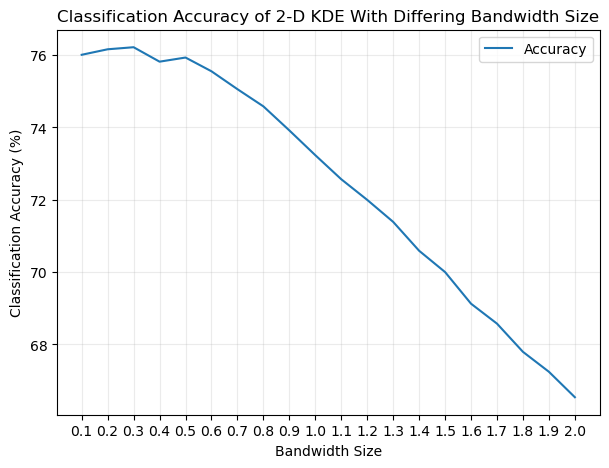

In [21]:
x_2d = [value[0] for value in results_2D]
y_2d = [value[1] for value in results_2D]


plt.figure(figsize=(7,5),dpi=100)
plt.plot(x_2d,y_2d,label='Accuracy')
plt.xticks(ticks=x_2d)
plt.xlabel('Bandwidth Size')
plt.ylabel('Classification Accuracy (%)')
plt.title('Classification Accuracy of 2-D KDE With Differing Bandwidth Size')
plt.legend()
plt.grid(True,alpha=0.25)
plt.show()

We can see that our 2-D KDE was most successful with a bandwidth value of `0.3`, at slightly over `76%`. Again, we can see that as the bandwidth size continues to increase, our classification accuracy decreases.

## Using K-Nearest Neighbors to Predict Runner Genders

We are now going to look at how well the k-Nearest Neighbors algorithm performs at classifying the sex of a runner given the runners that finished just before or after them. We will use `k=10` here for our algorithm. First lets look at the kernel density estimates of finish times of runners for both male and try to predict how our kNN classifier will perform. We will set the bandwidth parameter here to be quite small so that we can get a better sense of male and female runner distributions.

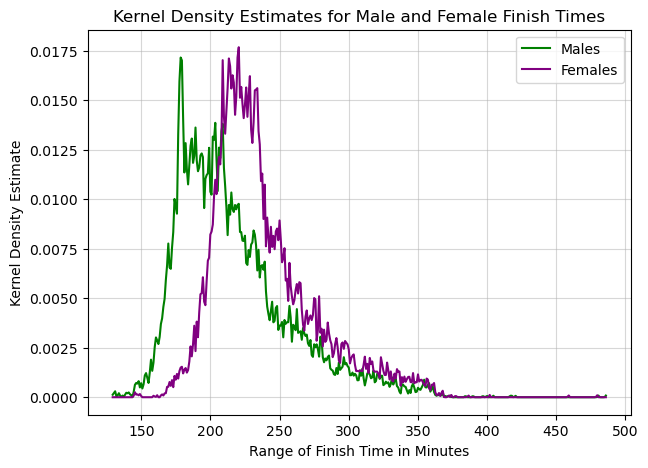

In [22]:
male_times_df = marathon_train_df[marathon_train_df['M/F']=='M']
female_times_df = marathon_train_df[marathon_train_df['M/F']=='F']

kde_male = gaussian_kde(male_times_df['tot_minutes'], bw_method=.01)
kde_female = gaussian_kde(female_times_df['tot_minutes'], bw_method=.01)

plt.figure(figsize=(7, 5),dpi=100)
x = np.linspace(male_times_df['tot_minutes'].min(),male_times_df['tot_minutes'].max(),400)
plt.plot(x, kde_male(x),label='Males',color='green')
plt.plot(x, kde_female(x),label='Females',color='purple')
plt.grid(True,alpha=0.5)
plt.xlabel('Range of Finish Time in Minutes')
plt.ylabel('Kernel Density Estimate')
plt.title('Kernel Density Estimates for Male and Female Finish Times')
plt.legend()
plt.show()

We can see that before the `~175` minute mark, we mostly have male runners. The kNN classifier should perform well here. Once we reach to about the `200` minute mark, we can see that there is a pretty even distribution of male and female runners. At this point our kNN classifier should perform at a pretty random rate of around `50%` as every runner should have a roughly even distribution of both male and female runners that finish just before and after them. With these points in mind, it would make sense that overall our k-NN classifier would perform at over a `50%` success rate. This can be attributed to getting a lot of the male runners with sub-200 minute times correct, and then going at about a `50%` success rate the rest of the way.

### 1-D k-NN: Using Only Finish Times

In [23]:
k=10
neigh=KNeighborsClassifier(n_neighbors=k)
neigh.fit(marathon_train_df[['tot_minutes']],marathon_train_df['M/F'])

# 1-D kNN
knn_pred = neigh.predict(marathon_test_df[['tot_minutes']])
# This line creates a boolean array 'compare' whose values are either True or False, true if the prediction
# is equal to the actual runner data, and false if not
compare = np.array(knn_pred) == np.array(marathon_test_df['M/F'])
# The .sum() method will compute how many True values are in the the 'compare' array
compare.sum() / len(compare) * 100

61.82509505703422

### 2-D k-NN: Using Finish Times and Age

In [24]:
k=10
neigh=KNeighborsClassifier(n_neighbors=k)
neigh.fit(marathon_train_df[['tot_minutes','Age']],marathon_train_df['M/F'])

# 2-D kNN
knn_pred = neigh.predict(marathon_test_df[['tot_minutes','Age']])
compare = np.array(knn_pred) == np.array(marathon_test_df['M/F'])
compare.sum() / len(compare) * 100

74.1254752851711

We can see that our k-NN classifier performed pretty well at classifying runners with a k value of 10. The k-NN classifier was just slightly worse than the KDE percentage wise than the KDE classifier for both the 1-D and 2-D cases. 

The `1-D KDE` was correct about `65%` of the time compared to the `1-D kNN` being correct about `61%` of the time, while The `2-D KDE` was correct about `76%` of the time compared to the `2-D kNN` being correct about `74%` of the time. These results confirm our prediction that our k-NN classifier would perform at over a `50%` success rate.

## Using Linear Regression

We will now make use of linear regression to predict finish times (in minutes) for runners. Linear regression models the relationship between a dependent variable and one or more independent variables. In this case the independent variables will be data such as 5k times, age, gender, etc. The dependent variable will be the finish time in minutes. We will first start with only using a runner's 5k time to predict their finish time. The predicted finish time of the runner will be stored in minutes under the column named 'regression'.

### Using Only 5K Times:

In [25]:
marathon_results_df = pd.read_csv('marathon_results.csv')
# Convert 5k time and finish time to minutes
marathon_results_df['5k_tot_minutes'] = pd.to_timedelta(marathon_results_df['5K']).dt.total_seconds()/60
marathon_results_df['tot_minutes'] = pd.to_timedelta(marathon_results_df['Finish']).dt.total_seconds()/60

# Create a linear regression for desired variables
reg1 = LinearRegression()

reg1.fit(marathon_results_df[['5k_tot_minutes']],marathon_results_df['tot_minutes'])
# This column will be our predicted finish time
marathon_results_df['regression'] = reg1.predict(marathon_results_df[['5k_tot_minutes']])

marathon_results_df

,Age,M/F,Country,5K,10K,15K,20K,Half,25K,30K,35K,40K,Finish,Pace,Overall,Gender,Division,5k_tot_minutes,tot_minutes,regression
0,25,M,ETH,00:14:43,00:29:43,00:44:57,01:00:29,01:04:02,01:16:07,01:32:00,01:47:59,02:02:39,02:09:17,00:04:56,1,1,1,14.716667,129.283333,127.007239
1,30,M,ETH,00:14:43,00:29:43,00:44:58,01:00:28,01:04:01,01:16:07,01:31:59,01:47:59,02:02:42,02:09:48,00:04:58,2,2,2,14.716667,129.800000,127.007239
2,29,M,KEN,00:14:43,00:29:43,00:44:57,01:00:29,01:04:02,01:16:07,01:32:00,01:47:59,02:03:01,02:10:22,00:04:59,3,3,3,14.716667,130.366667,127.007239
3,28,M,KEN,00:14:43,00:29:44,00:45:01,01:00:29,01:04:02,01:16:07,01:32:00,01:48:03,02:03:47,02:10:47,00:05:00,4,4,4,14.716667,130.783333,127.007239
4,32,M,KEN,00:14:43,00:29:44,00:44:58,01:00:28,01:04:01,01:16:07,01:32:00,01:47:59,02:03:27,02:10:49,00:05:00,5,5,5,14.716667,130.816667,127.007239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26293,64,F,USA,00:50:15,01:43:31,02:36:53,03:32:26,03:43:46,04:25:53,05:19:44,06:17:19,07:13:34,07:38:56,00:17:31,26594,12015,269,50.250000,458.933333,452.549834
26294,61,F,USA,00:48:36,01:39:39,02:39:13,03:35:58,03:47:55,04:32:44,05:31:58,06:28:56,07:26:19,07:51:30,00:17:59,26595,12016,270,48.600000,471.500000,437.433175
26295,66,F,USA,00:53:03,01:47:16,02:41:45,03:37:07,03:48:21,04:33:51,05:38:56,06:38:51,07:36:18,07:59:33,00:18:18,26596,12017,91,53.050000,479.550000,478.202346
26296,53,M,USA,00:49:04,01:40:12,02:33:31,03:31:41,03:43:35,04:29:20,05:31:11,06:33:35,07:35:38,08:00:37,00:18:20,26597,14580,2055,49.066667,480.616667,441.708594


### How Accurate Are These Regression Predictions?

To show how accurate our predictions were, we will use `Root Mean Squared Error(RMSE)` to show how far on average the regression model's predicted finish times varied from the actual finish times. To calculate the `RMSE`, we will first compute the `Mean Squared Error(MSE)` of the column `regression_error`, and then take the square root of it to obtain the `RMSE`.

The `MSE` is calculated by taking the difference of the `regression` and `tot_minutes` column for each runner, squared, and then sum up all of these squared differences. We then divide by the total number of runners to find the average `MSE`. We will store these squared differences under the `regression_error_squared` column of our dataframe.

In [26]:
# Compute the squared error
marathon_results_df['regression_error_squared'] = (marathon_results_df['regression'] - 
                                                   marathon_results_df['tot_minutes']) ** 2

# Get all of the values from this column 
regression_error_squared = marathon_results_df['regression_error_squared'].values 
# Compute Mean Squared Error
mse = np.mean(regression_error_squared)
# Compute Root Mean Squared Error
rmse = np.sqrt(mse)
rmse

15.947372563465944

We can see that our regression model was able to predict the finish time of a runner with about `+/- 16` minutes of error, on average.

### Using Age and 5K Times

In [27]:
marathon_results_df = pd.read_csv('marathon_results.csv')
marathon_results_df['5k_tot_minutes'] = pd.to_timedelta(marathon_results_df['5K']).dt.total_seconds()/60
marathon_results_df['tot_minutes'] = pd.to_timedelta(marathon_results_df['Finish']).dt.total_seconds()/60

reg3 = LinearRegression()

reg3.fit(marathon_results_df[['Age','5k_tot_minutes']],marathon_results_df['tot_minutes'])
marathon_results_df['regression'] = reg3.predict(marathon_results_df[['Age','5k_tot_minutes']])
marathon_results_df['regression_error_squared'] = (marathon_results_df['regression'] - 
                                                   marathon_results_df['tot_minutes']) ** 2

regression_error_squared = marathon_results_df['regression_error_squared'].values 
mse = np.mean(regression_error_squared)
rmse = np.sqrt(mse)
rmse

15.831065146565205

### Using Age and Halfway Times

In [28]:
marathon_results_df = pd.read_csv('marathon_results.csv')
marathon_results_df['Half_tot_minutes'] = pd.to_timedelta(marathon_results_df['Half']).dt.total_seconds()/60
marathon_results_df['tot_minutes'] = pd.to_timedelta(marathon_results_df['Finish']).dt.total_seconds()/60

reg4 = LinearRegression()

reg4.fit(marathon_results_df[['Age','Half_tot_minutes']],marathon_results_df['tot_minutes'])
marathon_results_df['regression'] = reg4.predict(marathon_results_df[['Age','Half_tot_minutes']])
marathon_results_df['regression_error_squared'] = (marathon_results_df['regression'] - 
                                                   marathon_results_df['tot_minutes']) ** 2

regression_error_squared = marathon_results_df['regression_error_squared'].values 
mse = np.mean(regression_error_squared)
rmse = np.sqrt(mse)
rmse

10.390138987177714

### Applying Linear Regression When Using Categorical Values

When we look at our dataset we can see that the `M/F` column, which signifies whether the runner was male or females, has values of either `M` or `F`. When using linear regression, we will need actual `integer` or `float` values to calculate our regression. So we will have to assign a `1` to males and `0` to females (or vice versa) in order to do this, because they are categorical values. `[2]`

However doing this can skew our regression model, as it would introduce an implcit relationship between males and females, saying that the sex with a value of `1` would be considered to be "1 more unit greater" than the sex that we assign a value of zero to. And we know that this won't be inherently true, as the sex of a runner is not exactly a true predictor of their finish times due to the different genetics, fitness level, strength, experience, etc. having the real impact on how fast a runner can finish the marathon.

To be able to label and analyze these categorical values in our regression model, we will use `one-hot encoding` for categorical values. One-hot encoding will avoid the problem previously stated by creating separate binary variables for each category, with each variable indicating whether or not the runner belongs to that category. This will prevent any implicit numerical ordering from skewing the results of our regression. `[2]`

To do this we will use `pandas.get_dummies()` `[3]`, which creates binary columns for each unique value in a categorical column of a Pandas dataframe. The `get_dummies()` function also has a neat parameter named `prefix` than will name every column with any prefix you want, followed by the different values of each category. Let's apply this to our dataframe and first see how well a linear regression model looking solely at gender preforms:

In [29]:
marathon_results_df = pd.read_csv('marathon_results.csv')
# Apply one-hot encoding to the 'M/F' column (this creates new dataframe)
one_hot_encoded = pd.get_dummies(marathon_results_df['M/F'], prefix='Sex_1H')
# Concatenate the two dataframes
marathon_results_df = pd.concat([marathon_results_df, one_hot_encoded], axis=1) 
marathon_results_df['tot_minutes'] = pd.to_timedelta(marathon_results_df['Finish']).dt.total_seconds()/60
marathon_results_df

,Age,M/F,Country,5K,10K,15K,20K,Half,25K,30K,35K,40K,Finish,Pace,Overall,Gender,Division,Sex_1H_F,Sex_1H_M,tot_minutes
0,25,M,ETH,00:14:43,00:29:43,00:44:57,01:00:29,01:04:02,01:16:07,01:32:00,01:47:59,02:02:39,02:09:17,00:04:56,1,1,1,0,1,129.283333
1,30,M,ETH,00:14:43,00:29:43,00:44:58,01:00:28,01:04:01,01:16:07,01:31:59,01:47:59,02:02:42,02:09:48,00:04:58,2,2,2,0,1,129.800000
2,29,M,KEN,00:14:43,00:29:43,00:44:57,01:00:29,01:04:02,01:16:07,01:32:00,01:47:59,02:03:01,02:10:22,00:04:59,3,3,3,0,1,130.366667
3,28,M,KEN,00:14:43,00:29:44,00:45:01,01:00:29,01:04:02,01:16:07,01:32:00,01:48:03,02:03:47,02:10:47,00:05:00,4,4,4,0,1,130.783333
4,32,M,KEN,00:14:43,00:29:44,00:44:58,01:00:28,01:04:01,01:16:07,01:32:00,01:47:59,02:03:27,02:10:49,00:05:00,5,5,5,0,1,130.816667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26293,64,F,USA,00:50:15,01:43:31,02:36:53,03:32:26,03:43:46,04:25:53,05:19:44,06:17:19,07:13:34,07:38:56,00:17:31,26594,12015,269,1,0,458.933333
26294,61,F,USA,00:48:36,01:39:39,02:39:13,03:35:58,03:47:55,04:32:44,05:31:58,06:28:56,07:26:19,07:51:30,00:17:59,26595,12016,270,1,0,471.500000
26295,66,F,USA,00:53:03,01:47:16,02:41:45,03:37:07,03:48:21,04:33:51,05:38:56,06:38:51,07:36:18,07:59:33,00:18:18,26596,12017,91,1,0,479.550000
26296,53,M,USA,00:49:04,01:40:12,02:33:31,03:31:41,03:43:35,04:29:20,05:31:11,06:33:35,07:35:38,08:00:37,00:18:20,26597,14580,2055,0,1,480.616667


We can see now exactly how the `get_dummies()` function works, and now the categorical value for sex of the runner has been assigned either `0 1` for males and `1 0` for females. Now let's see how well a regression model using only gender works:

In [30]:
reg5 = LinearRegression()

reg5.fit(marathon_results_df[['Sex_1H_M','Sex_1H_F']],marathon_results_df['tot_minutes'])
marathon_results_df['regression'] = reg5.predict(marathon_results_df[['Sex_1H_M','Sex_1H_F']])
marathon_results_df['regression_error_squared'] = (marathon_results_df['regression'] - 
                                                   marathon_results_df['tot_minutes']) ** 2

regression_error_squared = marathon_results_df['regression_error_squared'].values 
mse = np.mean(regression_error_squared)
rmse = np.sqrt(mse)
rmse

38.787866871688564

We can see that using only genders produces a much higher `Root-Mean Squared Error` value than our previous regression models. This helps to prove our previous point that the gender of the runner is not a true predictor of marathon performance. 

### Using Age, Gender, 5K, and Halfway Times

Let's see if we can improve upon this by looking at gender, age, 5K times, and halfway times to see if a model that only looks at pre-race data as well as data from the first half of the race can accurately predict the results of a runner.

In [31]:
marathon_results_df = pd.read_csv('marathon_results.csv')
one_hot_encoded = pd.get_dummies(marathon_results_df['M/F'], prefix='Sex_1H')
marathon_results_df = pd.concat([marathon_results_df, one_hot_encoded], axis=1) 
marathon_results_df['5k_tot_minutes'] = pd.to_timedelta(marathon_results_df['5K']).dt.total_seconds()/60
marathon_results_df['Halfway_minutes'] = pd.to_timedelta(marathon_results_df['Half']).dt.total_seconds()/60
marathon_results_df['tot_minutes'] = pd.to_timedelta(marathon_results_df['Finish']).dt.total_seconds()/60

reg6 = LinearRegression()

reg6.fit(marathon_results_df[['Age','Sex_1H_M','Sex_1H_F','5k_tot_minutes','Halfway_minutes']],marathon_results_df['tot_minutes'])
marathon_results_df['regression'] = reg6.predict(marathon_results_df[['Age','Sex_1H_M','Sex_1H_F','5k_tot_minutes','Halfway_minutes']])
marathon_results_df['regression_error'] = (marathon_results_df['regression'] - marathon_results_df['tot_minutes'])
marathon_results_df['regression_error_squared'] = (marathon_results_df['regression'] - 
                                                   marathon_results_df['tot_minutes']) ** 2

regression_error_squared = marathon_results_df['regression_error_squared'].values 
mse = np.mean(regression_error_squared)
rmse = np.sqrt(mse)
rmse

9.757739778056738

We can see that this improves our model quite a bit, on average the model was able to predict the finish times of the runner to within `+/- 9.75` minutes. Lets see how the frequencies for the regression errors looks like:

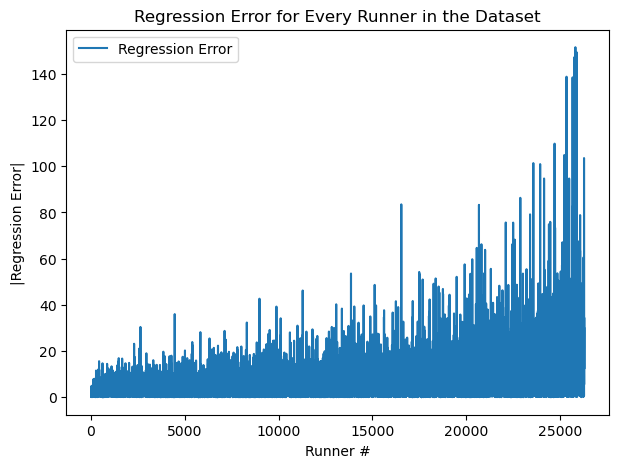

In [32]:
plt.figure(figsize=(7,5),dpi=100)
plt.plot(marathon_results_df.index,abs(marathon_results_df['regression_error']),label='Regression Error')
plt.xlabel('Runner #')
plt.ylabel('|Regression Error|')
plt.legend()
plt.title('Regression Error for Every Runner in the Dataset')
plt.show()

We can see here that the regression error using age, gender, 5k, and halfway times increases as we go down the list of runners finish times. This may be because runners who finished with a higher race time could have been 
less able to run the full course of a marathon at steady pace versus the more talented runners who finished with a low race time. These runners who were slower most likely had a slower pace in the 2nd half of the race when compared to the first half. Since our model only used their first half times, it was unable to accurately predict finish times for runners whose pace worsened in the second half. Our model worked well with the top runners, who most likely kept a relatively similiar pace throughout the entire race.

## Age, Gender, and Quarter Split Times

Let's see if using three times, 10k, 20k, and 30k, along with age and gender to see if this improves our model. 10k, 20k, and 30k approximately represent the first three quarters of the race.

In [33]:
marathon_results_df = pd.read_csv('marathon_results.csv')
one_hot_encoded = pd.get_dummies(marathon_results_df['M/F'], prefix='Sex_1H')
marathon_results_df = pd.concat([marathon_results_df, one_hot_encoded], axis=1) 
marathon_results_df['10k_tot_minutes'] = pd.to_timedelta(marathon_results_df['10K']).dt.total_seconds()/60
marathon_results_df['20k_tot_minutes'] = pd.to_timedelta(marathon_results_df['20K']).dt.total_seconds()/60
marathon_results_df['30k_tot_minutes'] = pd.to_timedelta(marathon_results_df['30K']).dt.total_seconds()/60
marathon_results_df['tot_minutes'] = pd.to_timedelta(marathon_results_df['Finish']).dt.total_seconds()/60

reg7 = LinearRegression()

reg7.fit(marathon_results_df[['Age','Sex_1H_M','Sex_1H_F','10k_tot_minutes','20k_tot_minutes','30k_tot_minutes']],marathon_results_df['tot_minutes'])
marathon_results_df['regression'] = reg7.predict(marathon_results_df[['Age','Sex_1H_M','Sex_1H_F','10k_tot_minutes','20k_tot_minutes','30k_tot_minutes']])
marathon_results_df['regression_error'] = (marathon_results_df['regression'] - marathon_results_df['tot_minutes'])
marathon_results_df['regression_error_squared'] = (marathon_results_df['regression'] - 
                                                   marathon_results_df['tot_minutes']) ** 2

regression_error_squared = marathon_results_df['regression_error_squared'].values 
mse = np.mean(regression_error_squared)
rmse = np.sqrt(mse)
rmse

6.063717269469273

We can see that our model improved by a noticeable margin, able to predict the finish time of a runner to within `+/- 6` minutes on average. Let's see if the distributions of the regression error improved:

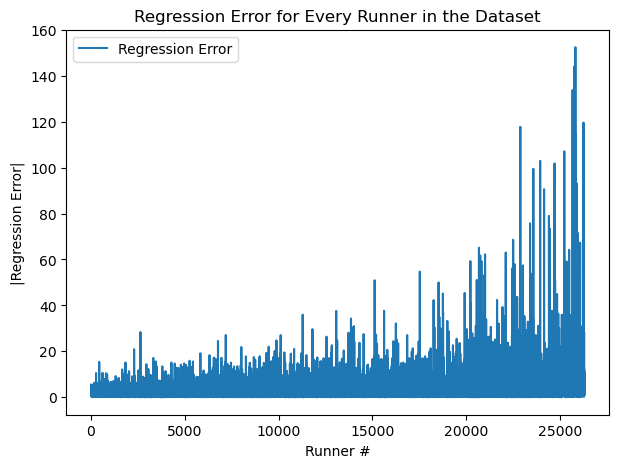

In [34]:
plt.figure(figsize=(7,5),dpi=100)
plt.plot(marathon_results_df.index,abs(marathon_results_df['regression_error']),label='Regression Error')
plt.xlabel('Runner #')
plt.ylabel('|Regression Error|')
plt.legend()
plt.title('Regression Error for Every Runner in the Dataset')
plt.show()

We can see that our model was better able to predict the finish time of about the first 70-80% of the runners in the marathon. We do not see large spikes in the regression error until around the bottom 10% of the runners, whose pace most likely increasingly slowed as the race went on. 

## Conclusion

In this report we explored several different methods to predict both the sex and finish time of a runner given different datapoints. We started by using Kernel Density Estimates in conjunction with Bayesian Inference to predict whether or not a runner was a female by first looking at their finish times (1-D), and then their age and finish times (2-D). When using 1-dimensional KDE, we were able to  able to predict if a runner was female at about a `65%` success rate. When using the 2-dimensional KDE, we were able to improve the classification accuracy up to `76%` rate.

We then used a k-Nearest Neighbor classifier to predict the sex of a runner. We started with a 1-D kNN, which was able to predict the sex of a runner with a `61%` accuracy. When switching to a 2-D k-NN, our accuracy improved to `74%`. 

Lastly, we wused linear regression modeling to predict the finish time of a runner given certain parameters. When using only 5k times, our regression model was able to predict the finish time of a runner to within about `+/-16` minutes. To improve upon this, we looked at multiple parameters such as the runner's age and halfway time splits. When doing this we were able to improve our model to be predicting the finish times to within about `+/-10` minutes. We ended by looking at the age of the runner, categorical data such as the sex of a runner, and all of their 1/4 time splits in the race. This model used one-hot encoding to be able to assign a value to the runner's `M/F` column which only had string values of either `M` or `F`. This model was much more accurate, able to predict the runner's finish time to within `+/-6` minutes on average.

## Code

In [ ]:
mport pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from scipy.stats import norm, gaussian_kde
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

marathon_results_df = pd.read_csv('marathon_results.csv')
marathon_results_df['tot_minutes'] = pd.to_timedelta(marathon_results_df['Finish']).dt.total_seconds()/60
marathon_results_df.head(1)

marathon_train_df,marathon_test_df = train_test_split(marathon_results_df,test_size=0.2,random_state=123)

male_times_df = marathon_train_df[marathon_train_df['M/F']=='M']
female_times_df = marathon_train_df[marathon_train_df['M/F']=='F']

## 1-D KDE

In [ ]:
prob_male = len(male_times) / (len(male_times)+len(female_times))
prob_female = len(female_times) / (len(male_times)+len(female_times))
print('Males: {:}%'.format(prob_male*100))
print('Females: {:}%'.format(prob_female*100))

def bayes_prediction_1D_KDE(testing_data,kde_males,kde_females):
    runner_gender_predictions = []
    correct = 0
    
    # Iterate through each row of the dataframe
    for index,row in testing_data.iterrows():
        predicted_gender = ''
        tot_min = row['tot_minutes']
        gender = row['M/F']

        # Compute the kde of a total time for males/females
        prob_tot_minutes_given_male = kde_males(tot_min)
        prob_tot_minutes_given_female = kde_females(tot_min)
        # Compute P(totalMinutes)
        prob_tot_minutes = (prob_tot_minutes_given_female * prob_female) + (prob_tot_minutes_given_male * prob_male)
        # Now compute bayes for male/female
        probability_female_given_tot_minutes = (prob_tot_minutes_given_female * prob_female) / prob_tot_minutes
        probability_male_given_tot_minutes = (prob_tot_minutes_given_male * prob_male) / prob_tot_minutes


        # If probability for bayes female > bayes male, say that the runner was female and vice versa
        if probability_female_given_tot_minutes > probability_male_given_tot_minutes:
            predicted_gender = 'F'
        elif probability_female_given_tot_minutes < probability_male_given_tot_minutes: 
            predicted_gender = 'M'
        if predicted_gender == gender:
            correct += 1
        runner_gender_predictions.append(predicted_gender)
            
    return((correct/len(testing_data))*100,runner_gender_predictions)

# Calculate the KDE for males and females
kde_males = gaussian_kde(male_times,bw_method=.1)
kde_females = gaussian_kde(female_times,bw_method=.1)

bayes_prediction_1D_KDE(marathon_test_df,kde_males,kde_females)[0]

#class_acc_kde_1d = []
#for i in range(1,21,1): 
    #bw = i/10
    #kde_males_1D = gaussian_kde(male_times_df['tot_minutes'], bw_method=bw)
    #kde_females_1D = gaussian_kde(female_times_df['tot_minutes'], bw_method=bw)
    #accuracy = bayes_prediction_1D_KDE(marathon_test_df,kde_males_1D,kde_females_1D)[0]
    #class_acc_kde_1d.append((bw,accuracy))

#with open('accuracy_kde1D.txt','w') as f:
    #for line in class_acc_kde_1d:
        #f.write('{:} | {:}'.format(line[0],line[1]))
        #f.write('\n')


with open('accuracy_kde1D.txt','r') as f:
    # These values get stored in the file as a string with format: bandwidth | accuracy
    # Split on ' | ' and convert to float for visualization
    results_1D = np.array([value.strip().split(' | ') for value in f],dtype=float)

# ---- Graphing Results ----
x_1d = [value[0] for value in results_1D]
y_1d = [value[1] for value in results_1D]


plt.figure(figsize=(7,5),dpi=100)
plt.plot(x_1d,y_1d,label='Accuracy')
plt.xticks(ticks=x_2d)
plt.xlabel('Bandwidth Size')
plt.ylabel('Classification Accuracy (%)')
plt.title('Classification Accuracy of 1-D KDE With Differing Bandwidth Size')
plt.legend()
# Create a grid on the plot for visualization, 'alpha' parameter sets opacity
plt.grid(True,alpha=0.25)
plt.show()

## 2-D KDE

In [ ]:
def bayes_prediction_2D_KDE(testing_data,kde_males,kde_females):
    runner_gender_predictions = []
    correct = 0
    
    for index,row in testing_data.iterrows():
        predicted_gender = ''
        tot_min = row['tot_minutes']
        gender = row['M/F']
        age = row['Age']

        prob_tot_minutes_age_given_male = kde_males((tot_min,age)) 
        prob_tot_minutes_age_given_female = kde_females((tot_min,age))
        prob_tot_minutes_age = (prob_tot_minutes_age_given_female * prob_female) + (prob_tot_minutes_age_given_male * prob_male)
        probability_female_given_tot_minutes_age = (prob_tot_minutes_age_given_female * prob_female) / prob_tot_minutes_age
        probability_male_given_tot_minutes_age = (prob_tot_minutes_age_given_male * prob_male) / prob_tot_minutes_age


        if probability_female_given_tot_minutes_age > probability_male_given_tot_minutes_age:
            predicted_gender = 'F'
        elif probability_female_given_tot_minutes_age < probability_male_given_tot_minutes_age: 
            predicted_gender = 'M'
        if predicted_gender == gender:
            correct += 1
        runner_gender_predictions.append(predicted_gender)

    return((correct/len(testing_data))*100,runner_gender_predictions)

kde_males_2D = gaussian_kde(male_times_df[['tot_minutes','Age']].T, bw_method=.1)
kde_females_2D = gaussian_kde(female_times_df[['tot_minutes','Age']].T, bw_method=.1)

bayes_prediction_2D_KDE(marathon_test_df,kde_males_2D,kde_females_2D)[0]

#class_acc_kde_2d = []
#for i in range(1,21,1): 
    #bw = i/10
    #kde_males_2D = gaussian_kde(male_times_df[['tot_minutes','Age']].T, bw_method=bw)
    #kde_females_2D = gaussian_kde(female_times_df[['tot_minutes','Age']].T, bw_method=bw)
    #accuracy = bayes_prediction_2D_KDE(marathon_test_df,kde_males_2D,kde_females_2D)[0]
    #class_acc_kde_2d.append((bw,accuracy))


#with open('accuracy_kde2D.txt','w') as f:
    #for line in class_acc_kde_2d:
        #f.write('{:} | {:}'.format(line[0],line[1]))
        #f.write('\n')

with open('accuracy_kde2D.txt','r') as f:
    results_2D = np.array([value.strip().split(' | ') for value in f],dtype=float)

x_2d = [value[0] for value in results_2D]
y_2d = [value[1] for value in results_2D]


plt.figure(figsize=(7,5),dpi=100)
plt.plot(x_2d,y_2d,label='Accuracy')
plt.xticks(ticks=x_2d)
plt.xlabel('Bandwidth Size')
plt.ylabel('Classification Accuracy (%)')
plt.title('Classification Accuracy of 2-D KDE With Differing Bandwidth Size')
plt.legend()
plt.grid(True,alpha=0.25)
plt.show()

## kNN 

In [ ]:
male_times_df = marathon_train_df[marathon_train_df['M/F']=='M']
female_times_df = marathon_train_df[marathon_train_df['M/F']=='F']

kde_male = gaussian_kde(male_times_df['tot_minutes'], bw_method=.01)
kde_female = gaussian_kde(female_times_df['tot_minutes'], bw_method=.01)

plt.figure(figsize=(7, 5),dpi=100)
x = np.linspace(male_times_df['tot_minutes'].min(),male_times_df['tot_minutes'].max(),400)
plt.plot(x, kde_male(x),label='Males',color='green')
plt.plot(x, kde_female(x),label='Females',color='purple')
plt.grid(True,alpha=0.5)
plt.xlabel('Range of Finish Time in Minutes')
plt.ylabel('Kernel Density Estimate')
plt.title('Kernel Density Estimates for Male and Female Finish Times')
plt.legend()
plt.show()

k=10
neigh=KNeighborsClassifier(n_neighbors=k)
neigh.fit(marathon_train_df[['tot_minutes']],marathon_train_df['M/F'])

# 1-D kNN
knn_pred = neigh.predict(marathon_test_df[['tot_minutes']])
# This line creates a boolean array 'compare' whose values are either True or False, true if the prediction
# is equal to the actual runner data, and false if not
compare = np.array(knn_pred) == np.array(marathon_test_df['M/F'])
# The .sum() method will compute how many True values are in the the 'compare' array
compare.sum() / len(compare) * 100

k=10
neigh=KNeighborsClassifier(n_neighbors=k)
neigh.fit(marathon_train_df[['tot_minutes','Age']],marathon_train_df['M/F'])

# 2-D kNN
knn_pred = neigh.predict(marathon_test_df[['tot_minutes','Age']])
compare = np.array(knn_pred) == np.array(marathon_test_df['M/F'])
compare.sum() / len(compare) * 100

## Linear Regression

In [ ]:
marathon_results_df = pd.read_csv('marathon_results.csv')
# Convert 5k time and finish time to minutes
marathon_results_df['5k_tot_minutes'] = pd.to_timedelta(marathon_results_df['5K']).dt.total_seconds()/60
marathon_results_df['tot_minutes'] = pd.to_timedelta(marathon_results_df['Finish']).dt.total_seconds()/60

# Create a linear regression for desired variables
reg1 = LinearRegression()

reg1.fit(marathon_results_df[['5k_tot_minutes']],marathon_results_df['tot_minutes'])
# This column will be our predicted finish time
marathon_results_df['regression'] = reg1.predict(marathon_results_df[['5k_tot_minutes']])

marathon_results_df

# Compute the squared error
marathon_results_df['regression_error_squared'] = (marathon_results_df['regression'] - 
                                                   marathon_results_df['tot_minutes']) ** 2

# Get all of the values from this column 
regression_error_squared = marathon_results_df['regression_error_squared'].values 
# Compute Mean Squared Error
mse = np.mean(regression_error_squared)
# Compute Root Mean Squared Error
rmse = np.sqrt(mse)
rmse


In [ ]:
marathon_results_df = pd.read_csv('marathon_results.csv')
marathon_results_df['5k_tot_minutes'] = pd.to_timedelta(marathon_results_df['5K']).dt.total_seconds()/60
marathon_results_df['tot_minutes'] = pd.to_timedelta(marathon_results_df['Finish']).dt.total_seconds()/60

reg3 = LinearRegression()

reg3.fit(marathon_results_df[['Age','5k_tot_minutes']],marathon_results_df['tot_minutes'])
marathon_results_df['regression'] = reg3.predict(marathon_results_df[['Age','5k_tot_minutes']])
marathon_results_df['regression_error_squared'] = (marathon_results_df['regression'] - 
                                                   marathon_results_df['tot_minutes']) ** 2

regression_error_squared = marathon_results_df['regression_error_squared'].values 
mse = np.mean(regression_error_squared)
rmse = np.sqrt(mse)
rmse

In [ ]:
marathon_results_df = pd.read_csv('marathon_results.csv')
marathon_results_df['Half_tot_minutes'] = pd.to_timedelta(marathon_results_df['Half']).dt.total_seconds()/60
marathon_results_df['tot_minutes'] = pd.to_timedelta(marathon_results_df['Finish']).dt.total_seconds()/60

reg4 = LinearRegression()

reg4.fit(marathon_results_df[['Age','Half_tot_minutes']],marathon_results_df['tot_minutes'])
marathon_results_df['regression'] = reg4.predict(marathon_results_df[['Age','Half_tot_minutes']])
marathon_results_df['regression_error_squared'] = (marathon_results_df['regression'] - 
                                                   marathon_results_df['tot_minutes']) ** 2

regression_error_squared = marathon_results_df['regression_error_squared'].values 
mse = np.mean(regression_error_squared)
rmse = np.sqrt(mse)
rmse


In [ ]:
marathon_results_df = pd.read_csv('marathon_results.csv')
# Apply one-hot encoding to the 'M/F' column (this creates new dataframe)
one_hot_encoded = pd.get_dummies(marathon_results_df['M/F'], prefix='Sex_1H')
# Concatenate the two dataframes
marathon_results_df = pd.concat([marathon_results_df, one_hot_encoded], axis=1) 
marathon_results_df['tot_minutes'] = pd.to_timedelta(marathon_results_df['Finish']).dt.total_seconds()/60
marathon_results_df

reg5 = LinearRegression()

reg5.fit(marathon_results_df[['Sex_1H_M','Sex_1H_F']],marathon_results_df['tot_minutes'])
marathon_results_df['regression'] = reg5.predict(marathon_results_df[['Sex_1H_M','Sex_1H_F']])
marathon_results_df['regression_error_squared'] = (marathon_results_df['regression'] - 
                                                   marathon_results_df['tot_minutes']) ** 2

regression_error_squared = marathon_results_df['regression_error_squared'].values 
mse = np.mean(regression_error_squared)
rmse = np.sqrt(mse)
rmse


In [ ]:
marathon_results_df = pd.read_csv('marathon_results.csv')
one_hot_encoded = pd.get_dummies(marathon_results_df['M/F'], prefix='Sex_1H')
marathon_results_df = pd.concat([marathon_results_df, one_hot_encoded], axis=1) 
marathon_results_df['5k_tot_minutes'] = pd.to_timedelta(marathon_results_df['5K']).dt.total_seconds()/60
marathon_results_df['Halfway_minutes'] = pd.to_timedelta(marathon_results_df['Half']).dt.total_seconds()/60
marathon_results_df['tot_minutes'] = pd.to_timedelta(marathon_results_df['Finish']).dt.total_seconds()/60

reg6 = LinearRegression()

reg6.fit(marathon_results_df[['Age','Sex_1H_M','Sex_1H_F','5k_tot_minutes','Halfway_minutes']],marathon_results_df['tot_minutes'])
marathon_results_df['regression'] = reg6.predict(marathon_results_df[['Age','Sex_1H_M','Sex_1H_F','5k_tot_minutes','Halfway_minutes']])
marathon_results_df['regression_error'] = (marathon_results_df['regression'] - marathon_results_df['tot_minutes'])
marathon_results_df['regression_error_squared'] = (marathon_results_df['regression'] - 
                                                   marathon_results_df['tot_minutes']) ** 2

regression_error_squared = marathon_results_df['regression_error_squared'].values 
mse = np.mean(regression_error_squared)
rmse = np.sqrt(mse)
rmse

# --- Graphing Data ---

plt.figure(figsize=(7,5),dpi=100)
plt.plot(marathon_results_df.index,abs(marathon_results_df['regression_error']),label='Regression Error')
plt.xlabel('Runner #')
plt.ylabel('|Regression Error|')
plt.legend()
plt.title('Regression Error for Every Runner in the Dataset')
plt.show()

In [ ]:
marathon_results_df = pd.read_csv('marathon_results.csv')
one_hot_encoded = pd.get_dummies(marathon_results_df['M/F'], prefix='Sex_1H')
marathon_results_df = pd.concat([marathon_results_df, one_hot_encoded], axis=1) 
marathon_results_df['10k_tot_minutes'] = pd.to_timedelta(marathon_results_df['10K']).dt.total_seconds()/60
marathon_results_df['20k_tot_minutes'] = pd.to_timedelta(marathon_results_df['20K']).dt.total_seconds()/60
marathon_results_df['30k_tot_minutes'] = pd.to_timedelta(marathon_results_df['30K']).dt.total_seconds()/60
marathon_results_df['tot_minutes'] = pd.to_timedelta(marathon_results_df['Finish']).dt.total_seconds()/60

reg7 = LinearRegression()

reg7.fit(marathon_results_df[['Age','Sex_1H_M','Sex_1H_F','10k_tot_minutes','20k_tot_minutes','30k_tot_minutes']],marathon_results_df['tot_minutes'])
marathon_results_df['regression'] = reg7.predict(marathon_results_df[['Age','Sex_1H_M','Sex_1H_F','10k_tot_minutes','20k_tot_minutes','30k_tot_minutes']])
marathon_results_df['regression_error'] = (marathon_results_df['regression'] - marathon_results_df['tot_minutes'])
marathon_results_df['regression_error_squared'] = (marathon_results_df['regression'] - 
                                                   marathon_results_df['tot_minutes']) ** 2

regression_error_squared = marathon_results_df['regression_error_squared'].values 
mse = np.mean(regression_error_squared)
rmse = np.sqrt(mse)
rmse

# --- Graphing Data ---

plt.figure(figsize=(7,5),dpi=100)
plt.plot(marathon_results_df.index,abs(marathon_results_df['regression_error']),label='Regression Error')
plt.xlabel('Runner #')
plt.ylabel('|Regression Error|')
plt.legend()
plt.title('Regression Error for Every Runner in the Dataset')
plt.show()

## References

1. Guenther, W. C. (n.d.). Bayesian methods in environmental science: A tutorial. In J. Michael (Ed.), Statistical methods in environmental research (pp. 143-177). Duke University. Retrieved May 6, 2023, from https://sites.nicholas.duke.edu/statsreview/jmc/

2. Brownlee, J. (2019, October 7). Why one-hot encode data in machine learning? Machine Learning Mastery. https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/

3. pandas.get_dummies. (n.d.). pandas 1.3.1 documentation. Retrieved May 13, 2023, from https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html